In 1993, Vaughan Black and Nicholas Richter published [*Did She Mention My Name: Citation of Academic Authority by the Supreme Court of Canada](https://digitalcommons.schulichlaw.dal.ca/dlj/vol16/iss2/3/), 1985-1990* in the Dalhousie Law Journal. The article examined the citation practices of Supreme Court of Canada justices and found that, *inter alia* SCC judges cited 2 scholarly texts per judgement.

![](https://obiter.ai/blog/posts/2023-04-19-scc-citations/judge_prof.jpg)

To my knowledge, the study has not been repeated since. And little wonder: it was a labour intensive project. In addition to the two co-authors, the research team appears to have included three research assistants. They would review each set of judgements issued by the SCC, identify the citations, and then manually build a dataset.

In this notebook, I want to show how how we can use computational methodologies to repeat and extend this study with just a few hours of work. We will see how it goes, but my plan is to answer two questions:

- are SCC judges citing more or fewer scholarly texts per decision?
- who is cited the most?

My main ambition is to showcase what can be done when researchers have ready access to lots of legal data. Until recently, it was difficult for researchers to access law in bulk. Fortunately, Professor Sean Rehaag of Osgoode Hall Law School just published a [comprehensive dataset of SCC judgements](https://refugeelab.ca/bulk-data/scc/). I want to show one way how researchers can interact with this dataset.

We will begin by downloading the dataset and loading it into a Pandas dataframe. Pandas is like Excel for Python. It is a powerful tool for working with data. We will use it to clean the data and to answer our questions.

In [1]:
#first we import pandas to manage and manipulate the data
import pandas as pd
#we use the json library to read the data
import json
#we use requests to download the data
import requests

# Set variables
start_year = 1990  # We will pick up from the last year studied by Black and Richter
end_year = 2022  # Last year of data sought (2022 -)

# load data
base_ulr = 'https://raw.githubusercontent.com/Refugee-Law-Lab/scc_bulk_data/master/DATA/YEARLY/'

# retrieve the data
results = []
for year in range(start_year, end_year+1):
    url = base_ulr + f'{year}.json'
    results.extend(requests.get(url).json())

# convert to dataframe
df = pd.DataFrame(results)


In [42]:
# filter by language
df = df[df['language'] == 'en']

Now we can take a look at the data. Let's begin by looking at the first five rows.

In [43]:
df.head(5)

,citation,citation2,year,name,language,decision_date,source_url,scraped_timestamp,unofficial_text
0,[1990] 1 SCR 1005,,1990,R. v. Fitzgibbon,en,1990-05-17,https://decisions.scc-csc.ca/scc-csc/scc-csc/e...,2022-09-01,R. v. Fitzgibbon\nCollection\nSupreme Court Ju...
1,[1990] 1 SCR 1020,,1990,R. v. Saunders,en,1990-05-17,https://decisions.scc-csc.ca/scc-csc/scc-csc/e...,2022-09-01,R. v. Saunders\nCollection\nSupreme Court Judg...
2,[1990] 1 SCR 1025,,1990,R. v. Sioui,en,1990-05-24,https://decisions.scc-csc.ca/scc-csc/scc-csc/e...,2022-09-01,R. v. Sioui\nCollection\nSupreme Court Judgmen...
3,[1990] 1 SCR 1075,,1990,R. v. Sparrow,en,1990-05-31,https://decisions.scc-csc.ca/scc-csc/scc-csc/e...,2022-09-01,R. v. Sparrow\nCollection\nSupreme Court Judgm...
4,[1990] 1 SCR 1123,,1990,Reference re ss. 193 and 195.1(1)(C) of the cr...,en,1990-05-31,https://decisions.scc-csc.ca/scc-csc/scc-csc/e...,2022-09-01,Reference re ss. 193 and 195.1(1)(C) of the cr...


In [44]:
df.shape

(2677, 9)

This shows us how the data looks. On each row we have the citation, the year, the language, the decision_date, the source_url, the time Professor Rehaag scraped the data, at the text.

The interesting thing for our purposes (take my word for it, I won't reproduce a judgement here) is that the beginning of each SCC case includes a section entitled 'Authors cited' right before a section that always begins in capital letters explaining where the matter was appealed from. We can try to computationally isolate that section. We will use some regex magic to do this.

In [46]:
import re

def split_on_three_uppercase_letters(s):
    # Define a regex pattern to match three uppercase letters in a row
    pattern = r'[A-Z]{3}'
    # Use re.split to split the string based on the pattern
    result = re.split(pattern, s)
    return result

#split the text on the first occurence of 'Authors Cited'
first = df.loc[0, 'unofficial_text'].split('Authors Cited')[1]

#split the text as soon as three uppercase letters are found
result = split_on_three_uppercase_letters(first)[0]

print(result)


Canada. Law Reform Commission. Working Paper 5. Restitution and Compensation. Ottawa: Information Canada, 1974.
Duncan, Lewis. Bankruptcy in Canada, 3rd ed. By Lewis Duncan and John D. Honsberger. Toronto: Canadian Legal Authors, 1961.



Great! That worked really well. Let's break up the data a bit more so each citation is isolated.

In [47]:
cites = [citation for citation in result.split('\n') if citation != '']
cites

['Canada. Law Reform Commission. Working Paper 5. Restitution and Compensation. Ottawa: Information Canada, 1974.',
 'Duncan, Lewis. Bankruptcy in Canada, 3rd ed. By Lewis Duncan and John D. Honsberger. Toronto: Canadian Legal Authors, 1961.']

Now let's try to run this accross the entire dataset. There will certainly be problems that arise, but we can deal with them as they come up. We are going to make a new dataframe with citations.

In [48]:
master = pd.DataFrame()
count = 0
for idx,row in df.iterrows():
    try:
        first = row['unofficial_text'].split('Authors Cited')[1]
        result = split_on_three_uppercase_letters(first)[0]
        cites = [citation for citation in result.split('\n') if citation != '']
        for citation in cites:
            row_df = pd.DataFrame({'year': [row['year']],
                            'decision_citation': [row['citation']],
                            'cites': [citation]})
            master = pd.concat([master, row_df], axis=0, ignore_index=True)
    except:
        count += 1

print(f'There were {count} cases where this method failed.')

There were 1115 cases where this method failed.


So right away we get an error. It looks like in this decision there isn't a section entitled 'Authors cited'. Let's take a look at the text.

So there were 1115 cases where this didn't work. We can see what this was of the total by looking at the shape of the dataframe.

In [57]:
print(f'The dataframe has these dimensions: {df.shape}.')
math = int((1115/df.shape[0])*100)
print(f'This method failed on {math}% of the cases.')

The dataframe has these dimensions: (2677, 9).
This method failed on 41% of the cases.


It is probable that many of these cases just don't cite scholarly work. That would be our first interesting finding. But let's look to see if we can confirm that.

In [59]:
df['unofficial_text'].str.contains('Authors Cited').value_counts()

True     1562
False    1115
Name: unofficial_text, dtype: int64

Confirmed. If this were a real study, we would need to sample some decisions to confirm that that's the case. But for now let's assume that it is.

Let's see what we can learn about our citations by plotting the number of citations each year and the average number of citations per case, per year.

<AxesSubplot: xlabel='year'>

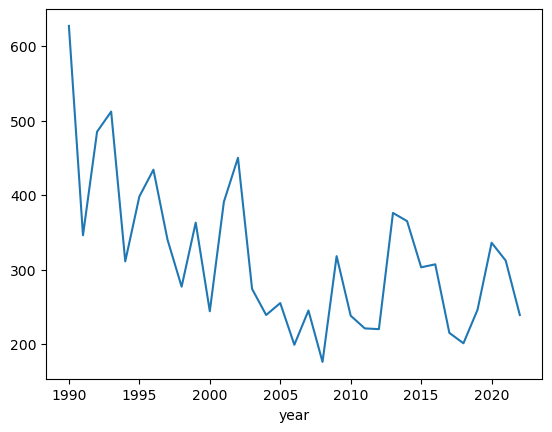

In [68]:
master.groupby('year')['decision_citation'].count().plot()

In [179]:
master

,year,decision_citation,cites,authors,title,publication,year_pub
0,1990,[1990] 1 SCR 1005,Canada. Law Reform Commission. Working Paper 5...,Canada. Law Reform Commission,Restitution and Compensation,Working Paper 5,1974
1,1990,[1990] 1 SCR 1005,"Duncan, Lewis. Bankruptcy in Canada, 3rd ed. B...","Duncan, Lewis; Honsberger, John D.","Bankruptcy in Canada, 3rd ed.",Book,1961
2,1990,[1990] 1 SCR 1025,Canadian Archives: Documents relating to the C...,"Shortt, Adam; Dought, Arthur G.",Documents relating to the Constitutional Histo...,Book,1907
3,1990,[1990] 1 SCR 1025,"Colden, Cadwallader. The History of the Five I...","Colden, Cadwallader",The History of the Five Indian Nations of Canada,book,1747
4,1990,[1990] 1 SCR 1025,"Garneau, François Xavier. Histoire du Canada f...","Garneau, François Xavier","Histoire du Canada français, t. 3",Les Amis de l'Histoire,1969
...,...,...,...,...,...,...,...
10458,2022,2022 SCC 9,"Lederman, Sidney N., Alan W. Bryant and Michel...","Lederman, Sidney N.; Bryant, Alan W.; Fuerst, ...","Sopinka, Lederman & Bryant: The Law of Evidenc...",book,2018
10459,2022,2022 SCC 9,"McWilliams’ Canadian Criminal Evidence, vols. ...","Hill, S. Casey; Tanovich, David M.; Strezos, L...","McWilliams’ Canadian Criminal Evidence, vols. ...",na,2022
10460,2022,2022 SCC 9,"Paciocco, David M., Palma Paciocco and Lee Stu...","Paciocco, David M.; Paciocco, Palma; Stuesser,...","The Law of Evidence, 8th ed.",book,2020
10461,2022,2022 SCC 9,"Salhany, Roger E. Canadian Criminal Procedure,...","Salhany, Roger E.","Canadian Criminal Procedure, vol. 1",book,2021


<AxesSubplot: xlabel='year'>

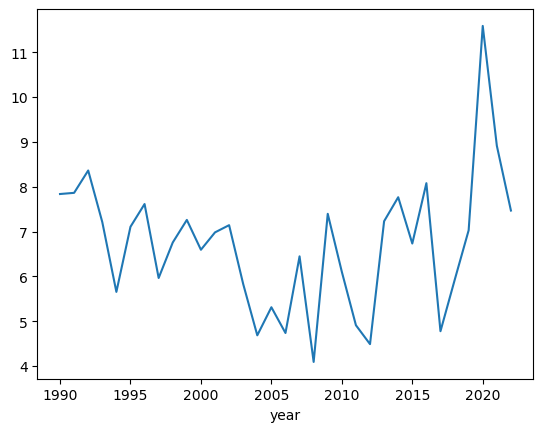

In [188]:
# group by year and case, then count number of citations
citations_count = master.groupby(['year', 'decision_citation'])['cites'].count()

# calculate the mean of the citations count per case per year
avg_citations = citations_count.groupby(level='year').mean()
avg_citations.plot()

So this shows that, for cases where there was a citation, the total number of citations per year looks to be trending down but, at least in the past few years, the average number of citations per case might be trending up a bit. The data is very noisy so it's hard to draw firm conclusions.

Now let's use some modern AI to build a more impressive dataset. I am going to use the AI models that power ChatGPT to extract information from each citation. In particular, I'm interested in getting the author and the title of the piece. We will also see if we can get the year of publication and the journal title, if available. Here, the art is to develop a prompt that explains to the AI model what we want it to return. Let's begin with some tests.

In [99]:
import openai
import ast

In [77]:
test_cites = list(master.loc[0:5,'cites'])
test_cites

['Canada. Law Reform Commission. Working Paper 5. Restitution and Compensation. Ottawa: Information Canada, 1974.',
 'Duncan, Lewis. Bankruptcy in Canada, 3rd ed. By Lewis Duncan and John D. Honsberger. Toronto: Canadian Legal Authors, 1961.',
 "Canadian Archives: Documents relating to the Constitutional History of Canada 1759-1791, 2nd and rev. ed., Part I. Edited by Adam Shortt and Arthur G. Dought. Ottawa: King's Printer.",
 'Colden, Cadwallader. The History of the Five Indian Nations of Canada. London: T. Osborne, 1747.',
 "Garneau, François Xavier. Histoire du Canada français, t. 3. Montréal: Les Amis de l'Histoire, 1969.",
 "Jésuites. Relations des jésuites contenant ce qui s'est passé de plus remarquable dans les missions des Pères de la Compagnie de Jésus dans la Nouvelle‑France, vol. 2. Québec: Augustin Côté, 1858."]

Now that we have these five citations, let's write a prompt that will extract information from them.

In [134]:
prompt = """
You are a tool used to extract bibliographic inforamtion from a citation.
Only return a dictionary object. Do not provide any other ouput.
Make sure all the keys are lowercase.
I will give you a citation and it is your job to return a dictionary object with the following keys:
-authors: (semi-colon separated list authors). This list should be of all the authors by last name, comma, first name. Do not include any middle initials.
-title: title of paper or book
-title of publication: journal the paper was published in. If it was published as a book, just say book. If it was published as a chapter in a book, return the title of the book
-year of publication: year it was published in

The most important thing is that the return be a dictionary object.
Do not provide feedback or explanations. Only return dictionary objects.
Do not provide notes. If you need to make a judgement call, make a judgement call. You are not verbose.
If the answer to any query is null, return "na" in quotation marks (like this: "na")."""

Now let's run the test.

In [193]:
for test in test_cites:
    res = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": test},
        ]
    )
    print(test)
    print(res['choices'][0]['message']['content'])

Canada. Law Reform Commission. Working Paper 5. Restitution and Compensation. Ottawa: Information Canada, 1974.
{
    "authors": "Commission, Canada Law Reform",
    "title": "Restitution and Compensation",
    "title of publication": "Working Paper 5",
    "year of publication": "1974"
}
Duncan, Lewis. Bankruptcy in Canada, 3rd ed. By Lewis Duncan and John D. Honsberger. Toronto: Canadian Legal Authors, 1961.
{'authors': 'Duncan, Lewis; Honsberger, John D.',
 'title': 'Bankruptcy in Canada, 3rd ed.',
 'title of publication': 'Book',
 'year of publication': '1961'}
Canadian Archives: Documents relating to the Constitutional History of Canada 1759-1791, 2nd and rev. ed., Part I. Edited by Adam Shortt and Arthur G. Dought. Ottawa: King's Printer.
{
    "authors": "Shortt, Adam G.; Dought, Arthur G.",
    "title": "Documents relating to the Constitutional History of Canada 1759-1791",
    "title of publication": "Book",
    "year of publication": "1907"
}
Colden, Cadwallader. The History 

This looks very good. We'll run it for the whole dataset now. This will incur some costs, and take a few hours, so be mindful.

In [155]:
for idx,row in master.iterrows():
    if idx % 100 == 0:
        print(f"This is iteration {idx}")
    
    cite = row['cites']
    flag = 'n'
    count = 0
    while flag == 'n':
        try:
            res = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                    {"role": "system", "content": prompt},
                    {"role": "user", "content": cite},
                ]
            )
            
            answer = ast.literal_eval(res['choices'][0]['message']['content'])
            master.loc[idx,'authors'] = answer['authors']
            master.loc[idx,'title'] = answer['title']
            master.loc[idx,'publication'] = answer['title of publication']
            master.loc[idx,'year_pub'] = answer['year of publication']
            flag = 'y'
        except:
            count += 1
            if count == 5:
                print(f'error {idx}')
                flag = 'y'
                master.loc[idx,'authors'] = 'error'
                master.loc[idx,'title'] = 'error'
                master.loc[idx,'publication'] = 'error'
                master.loc[idx,'year_pub'] = 'error'

This is iteration 0
This is iteration 100
This is iteration 200
This is iteration 300
This is iteration 400
This is iteration 500
This is iteration 600
This is iteration 700
This is iteration 800
This is iteration 900
This is iteration 1000
This is iteration 1100
This is iteration 1200
This is iteration 1300
This is iteration 1400
This is iteration 1500
This is iteration 1600
This is iteration 1700
This is iteration 1800
This is iteration 1900
This is iteration 2000
This is iteration 2100
This is iteration 2200
error 2204
error 2268
This is iteration 2300
error 2322
This is iteration 2400
error 2427
error 2454
This is iteration 2500
This is iteration 2600
This is iteration 2700
This is iteration 2800
This is iteration 2900
This is iteration 3000
This is iteration 3100
This is iteration 3200
This is iteration 3300
This is iteration 3400
This is iteration 3500
This is iteration 3600
This is iteration 3700
This is iteration 3800
This is iteration 3900
error 3978
error 3984
This is iterati

Let's save our results:

In [164]:
master.to_csv('results.csv')

And now let's do some exploratory analysis.

In [167]:
master['publication'].value_counts().head(30)

Book                                2832
book                                2039
na                                  1008
Can. Bar Rev.                        181
McGill L.J.                          116
House of Commons Debates             101
Crim. L.Q.                            91
C.R.                                  81
S.C.L.R.                              75
U.T.L.J.                              68
Alta. L. Rev.                         64
Can. Bus. L.J.                        55
R. du B.                              54
Osgoode Hall L.J.                     47
Queen’s L.J.                          45
U.B.C. L. Rev.                        37
Canadian Family Law Quarterly         35
Ottawa L. Rev.                        34
R.G.D.                                33
Harv. L. Rev.                         33
C. de D.                              33
R.J.T.                                32
Queen's L.J.                          27
Sask. L. Rev.                         26
N.J.C.L.        

In [192]:
master['authors'].value_counts().head(15)

na                                                     544
Sullivan, Ruth                                         132
Canada, House of Commons                               114
Hogg, Peter W                                           97
Driedger, Elmer A.                                      79
Stuart, Don                                             64
Côté, Pierre-André                                      54
Sopinka, John; Lederman, Sidney N.; Bryant, Alan W.     52
Canada                                                  52
Wigmore, John Henry                                     46
Canada. Law Reform Commission                           42
Hogg, Peter W.                                          39
Côté, Pierre‑André                                      37
Roach, Kent                                             35
Bala, Nicholas                                          33
Name: authors, dtype: int64

Ok, we can reach some tentative conclusions to our research questions.

1) The number of non-case citations has been trending down, but there may be a bit of a spike lately per case.
2) The most cited author is Peter Hogg (he shows up on the list twice). After Professor Hogg, Ruth Sullivan is the most cited scholar.
3) The most cited journal is the Canadian Bar Review.